In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karnikakapoor/art-portraits")

print("Path to dataset files:", path)

100%|██████████| 3.20G/3.20G [00:40<00:00, 83.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karnikakapoor/art-portraits/versions/3


In [21]:
# Define dataset pathroot
dataset_path = "/root/.cache/kagglehub/datasets/karnikakapoor/art-portraits/versions/3"

In [22]:
# Explore the dataset contents to locate the images
def explore_dataset_contents(folder):
    for root, dirs, files in os.walk(folder):
        print(f"Directory: {root}")
        for dir_name in dirs:
            print(f"  Subdirectory: {dir_name}")
        for file_name in files:
            print(f"  File: {file_name}")

In [23]:
# Print dataset structure
explore_dataset_contents(path)

Streaming output truncated to the last 5000 lines.
  File: image_5978.jpg
  File: image_3608.jpg
  File: image_2977.jpg
  File: image_1251.jpg
  File: image_1803.jpg
  File: image_3676.jpg
  File: image_6337.jpg
  File: image_2475.jpg
  File: image_1370.jpg
  File: image_5116.jpg
  File: image_4510.jpg
  File: image_45.jpg
  File: image_2177.jpg
  File: image_1332.jpg
  File: image_6002.jpg
  File: image_5971.jpg
  File: image_5984.jpg
  File: image_744.jpg
  File: image_3582.jpg
  File: image_873.jpg
  File: image_2375.jpg
  File: image_5031.jpg
  File: image_5905.jpg
  File: image_5818.jpg
  File: image_1719.jpg
  File: image_3420.jpg
  File: image_6484.jpg
  File: image_2708.jpg
  File: image_861.jpg
  File: image_4809.jpg
  File: image_2522.jpg
  File: image_2799.jpg
  File: image_5957.jpg
  File: image_198.jpg
  File: image_3089.jpg
  File: image_870.jpg
  File: image_2161.jpg
  File: image_5238.jpg
  File: image_1353.jpg
  File: image_5672.jpg
  File: image_5039.jpg
  File: image

In [24]:
# Update dataset path after exploration
DATASET_PATH = os.path.join(path, '/root/.cache/kagglehub/datasets/karnikakapoor/art-portraits/versions/3')

In [25]:
 #Helper function to load images
def load_images_from_folder(folder):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(subdir, file)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128))  # Resizing images to 128x128
                images.append(img)
    return np.array(images)


In [26]:
# Load dataset
images = load_images_from_folder(DATASET_PATH)
images = images.astype('float32') / 255.0  # Normalize images to [0, 1]
print(f"Loaded {len(images)} images.")


Loaded 10625 images.


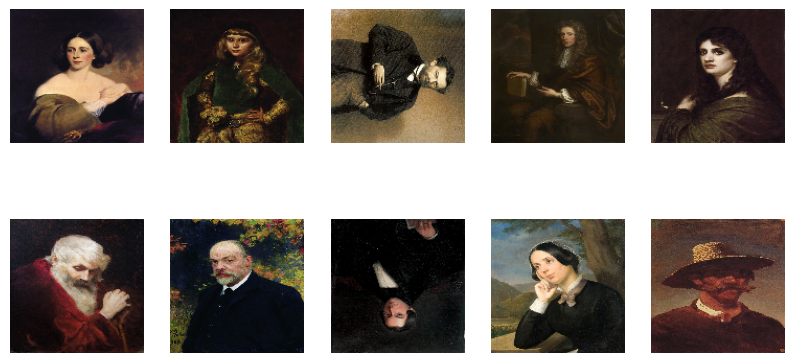

In [27]:
# Display a few images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [30]:
# Shuffle and split the dataset
from sklearn.utils import shuffle  # Ensure shuffle is properly imported
images = shuffle(images)
train_images, val_images = images[:int(0.9 * len(images))], images[int(0.9 * len(images)):]

In [35]:
# Step 2: Define Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(16 * 16 * 256, activation="relu", input_dim=100))
    model.add(Reshape((16, 16, 256)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return model


In [37]:
# Step 3: Define Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    return model

In [38]:
# Instantiate generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

In [39]:
# Step 4: Define GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))
    return gan

gan = build_gan(generator, discriminator)

In [40]:
# Step 5: Train GAN
def train_gan(generator, discriminator, gan, train_images, epochs=100, batch_size=32):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, train_images.shape[0], half_batch)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

train_gan(generator, discriminator, gan, train_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 [D loss: 0.697309136390686 | D accuracy: 0.3125] [G loss: [array(0.69596255, dtype=float32), array(0.69596255, dtype=float32), array(0.25, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [42]:
# Step 6: Evaluate Model using Inception Score
def inception_score(generator, noise_dim=100, num_images=1000):
    from scipy.stats import entropy
    from tensorflow.keras.applications import InceptionV3

    inception_model = InceptionV3(include_top=False, pooling="avg", input_shape=(128, 128, 3))

    noise = np.random.normal(0, 1, (num_images, noise_dim))
    labels = np.random.randint(0, 10, num_images).reshape(-1, 1)
    generated_images = generator.predict([noise, labels])

    preds = inception_model.predict(generated_images)
    kl_divs = [entropy(pred, np.mean(preds, axis=0)) for pred in preds]
    is_score = np.exp(np.mean(kl_divs))

    print(f"Inception Score: {is_score}")

In [43]:
# Evaluate the generator
inception_score(generator)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step
Inception Score: 1.070260763168335
